In [278]:
%matplotlib inline 
import pandas as pd
import numpy as np
import datetime
import calendar
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as  sm
import matplotlib.pyplot as plt
import matplotlib.pylab
from matplotlib.pylab import rcParams
from dateutil.relativedelta import relativedelta

In [279]:
idp_url = 'https://idp.nz/api/views/mm2r-3dj9/rows.csv'
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y')
data = pd.read_csv( idp_url, parse_dates='Day', index_col='Day', date_parser=dateparse)
# convert the column into a series object.
time_series = data[['Measure','Count','Parent Level Domain']] 

In [280]:
# count the number of Creates / uncancelled / cancelled per month since 2012.
startdate= datetime.date(2012,1,1)
# the observed number of months
length = 56 
# function to find the next month
def add_months(sourcedate,months):
    month = sourcedate.month - 1 + months
    year = int(sourcedate.year + month / 12 )
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year,month)[1])
    return datetime.date(year,month,day)
# function to count the number of domains 
number_created = []
number_uncancelled = []
number_cancelled = []
dates = []
def domain_counting(length):
    for i in range(length):
        if i==0:
            year = str(startdate.year)
            month = str(startdate.month)
            countdate = '-'.join((year,month))
            number_created.append(time_series[countdate][time_series[countdate]['Measure']== 'Created'].sum().Count)
            number_cancelled.append(time_series[countdate][time_series[countdate]['Measure']== 'Cancelled'].sum().Count)
            number_uncancelled.append(time_series[countdate][time_series[countdate]['Measure']== 'Uncancelled'].sum().Count)    
        else:
            newdate = add_months(startdate,i) #find the new date
            year = str(newdate.year)
            month = str(newdate.month)
            countdate = '-'.join((year,month))
            number_created.append(time_series[countdate][time_series[countdate]['Measure']== 'Created'].sum().Count)
            number_cancelled.append(time_series[countdate][time_series[countdate]['Measure']== 'Cancelled'].sum().Count)
            number_uncancelled.append(time_series[countdate][time_series[countdate]['Measure']== 'Uncancelled'].sum().Count)
        
        dates.append(countdate)   
        i += 1  
    return 
domain_counting(length)

In [281]:
#Create a dataframe to store the time series after counting.
df = pd.DataFrame({'Month':dates, 'Created': number_created, 'Cancelled': number_cancelled, 
                    'Uncancelled': number_uncancelled})
df2 = df[['Month', 'Created']]

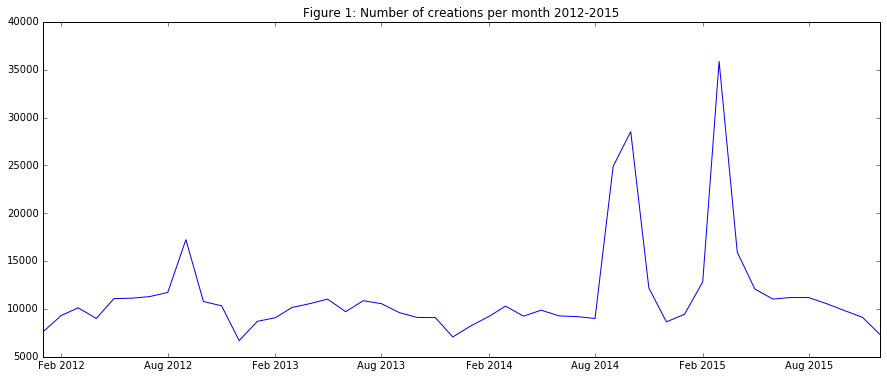

In [285]:
#Parse the data into time series data
data_created = df2.copy()
data_created['Month'] = pd.to_datetime(df2['Month'])
rcParams['figure.figsize'] = 15, 6
data_created = data_created.set_index('Month')
data_point = data_created['2012-01': '2015-12']
plt.plot(data_point)
plt.title('Figure 1: Number of creations per month 2012-2015')


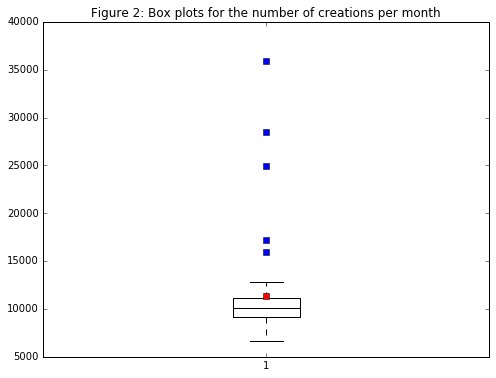

In [283]:
fig = plt.figure(figsize=(8,6))
bplot = plt.boxplot(data_point.Created,
            notch=False, 
            sym='rs',    
            vert=True,
         showmeans=True    )   
for components in bplot.keys():
    for line in bplot[components]:
        line.set_color('black')     
plt.title('Figure 2: Box plots for the number of creations per month')
plt.show()
mean = sum(data_point.Created) / float(len(data_point.Created))

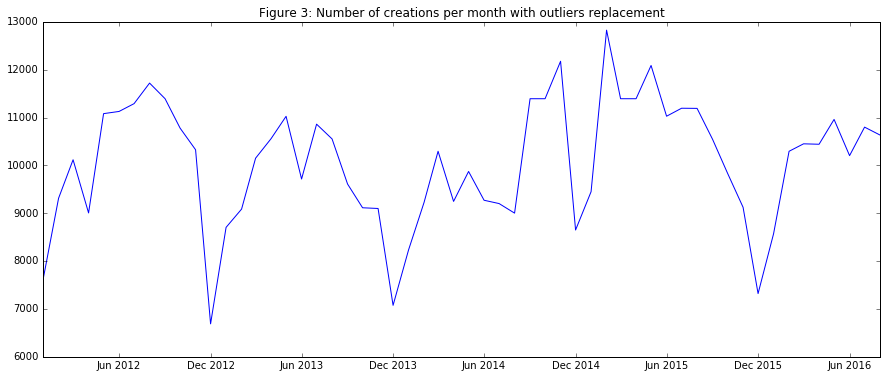

In [267]:
#get the index of the outliers.
outlier_index = data_point[data_point['Created'] > 15000].index.tolist()
ts = data_created['Created']
#replace the outliers with the mean
for i in outlier_index:
    ts[i] = 11396
# plot after outlier replacement
plt.plot(ts)
plt.title('Figure 3: Number of creations per month with outliers replacement')

/Users/huayi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/huayi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


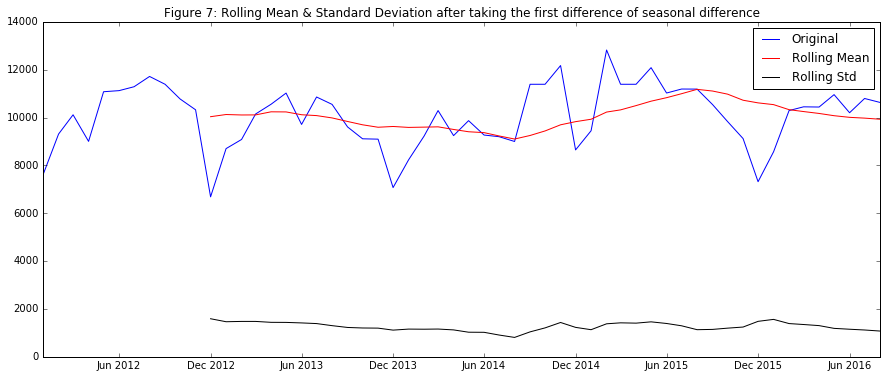

Results of Dickey-Fuller Test:
Test Statistic                 -4.402657
p-value                         0.000294
#Lags Used                      0.000000
Number of Observations Used    55.000000
Critical Value (10%)           -2.595670
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
dtype: float64


In [268]:
#function to test stationarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Figure 7: Rolling Mean & Standard Deviation after taking the first difference of seasonal difference')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    #dftest = adfuller(timeseries,1)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(ts)

/Users/huayi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/huayi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


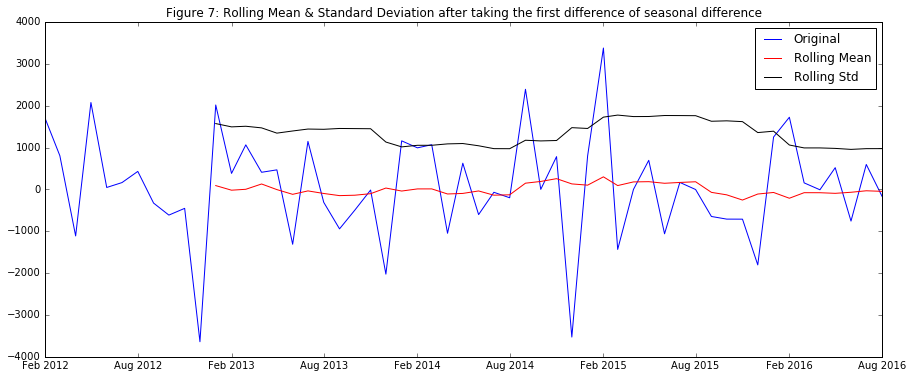

Results of Dickey-Fuller Test:
Test Statistic                 -2.048440
p-value                         0.265746
#Lags Used                     11.000000
Number of Observations Used    43.000000
Critical Value (10%)           -2.604066
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
dtype: float64


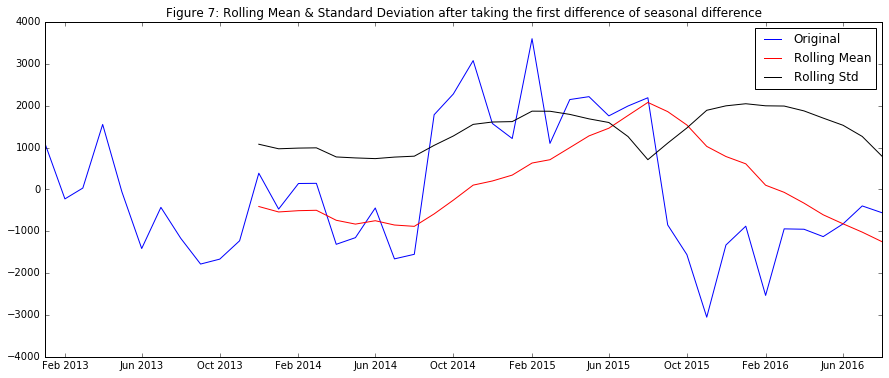

Results of Dickey-Fuller Test:
Test Statistic                 -2.818865
p-value                         0.055629
#Lags Used                      0.000000
Number of Observations Used    43.000000
Critical Value (10%)           -2.604066
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
dtype: float64


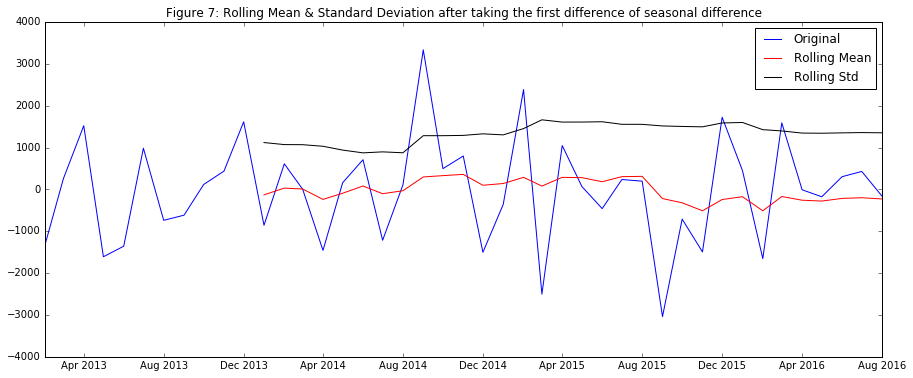

Results of Dickey-Fuller Test:
Test Statistic                -7.979531e+00
p-value                        2.646258e-12
#Lags Used                     0.000000e+00
Number of Observations Used    4.200000e+01
Critical Value (10%)          -2.604991e+00
Critical Value (1%)           -3.596636e+00
Critical Value (5%)           -2.933297e+00
dtype: float64


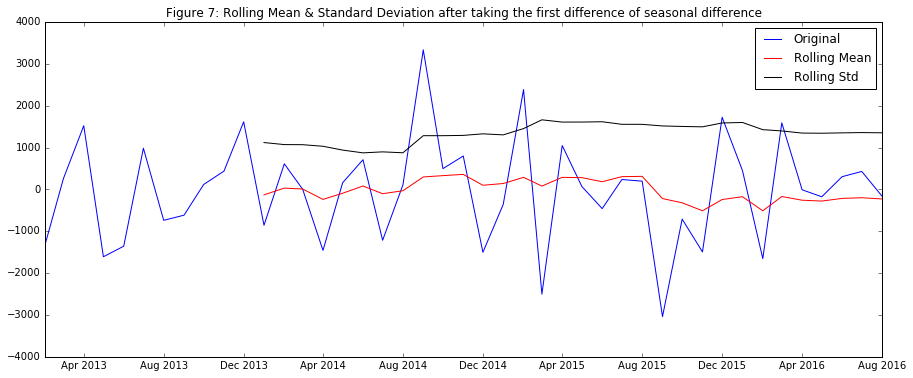

Results of Dickey-Fuller Test:
Test Statistic                -7.979531e+00
p-value                        2.646258e-12
#Lags Used                     0.000000e+00
Number of Observations Used    4.200000e+01
Critical Value (10%)          -2.604991e+00
Critical Value (1%)           -3.596636e+00
Critical Value (5%)           -2.933297e+00
dtype: float64


In [286]:
#first difference
#take_log_diff = take_log - take_log.shift() 
ts_first = ts - ts.shift()
#plt.plot(take_log_diff) 
ts_first.dropna(inplace=True)
test_stationarity(ts_first)

#seasonal difference
ts_season = ts - ts.shift(12) 
ts_season.dropna(inplace=True)
test_stationarity(ts_season)

#first + seasonal difference
ts_first_season = ts_first - ts_first.shift(12)
ts_first_season.dropna(inplace=True)
test_stationarity(ts_first_season)

#first difference of the seasonal difference

ts_new = ts_season - ts_season.shift()
ts_new.dropna(inplace=True)
test_stationarity(ts_new)


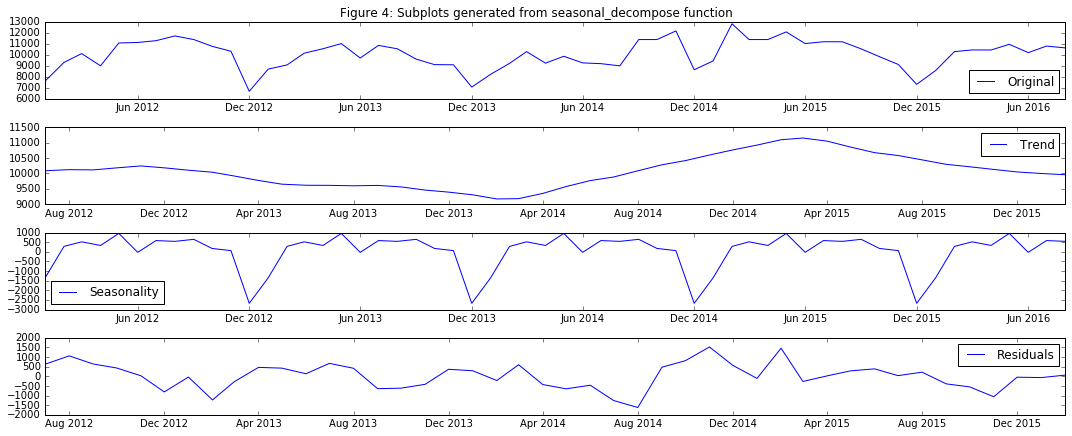

In [287]:

decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.suptitle('Figure 4: Subplots generated from seasonal_decompose function', fontsize=12, y=1)

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


/Users/huayi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/huayi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


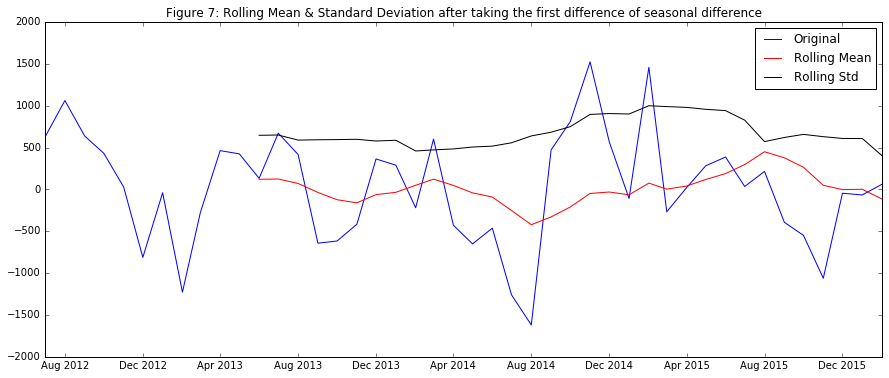

Results of Dickey-Fuller Test:
Test Statistic                 -4.300464
p-value                         0.000443
#Lags Used                      0.000000
Number of Observations Used    43.000000
Critical Value (10%)           -2.604066
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
dtype: float64


In [288]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

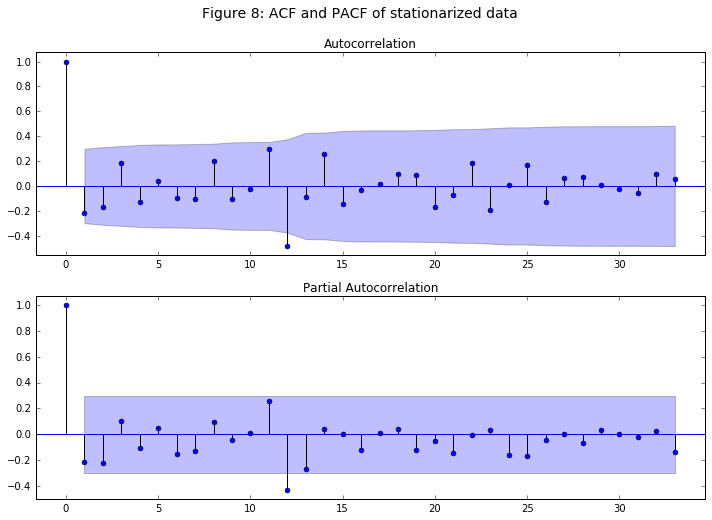

In [289]:
#ACF and PACF plots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_new.iloc[:], lags=33
                               , ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_new.iloc[:], lags=33, ax=ax2)
fig.suptitle('Figure 8: ACF and PACF of stationarized data', fontsize=14)

In [290]:
mod = statsmodels.tsa.statespace.sarimax.SARIMAX(ts, trend='n', order=(1,1,0), seasonal_order=(2,1,0,12), enforce_invertibility =True)
res = mod.fit()  ### return MLE results. in sample fit
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            Created   No. Observations:                   56
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -354.927
Date:                            Fri, 09 Sep 2016   AIC                            717.854
Time:                                    09:55:26   BIC                            725.956
Sample:                                01-01-2012   HQIC                           720.995
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3268      0.113     -2.882      0.004      -0.549      -0.105
ar.S.L12      -0.8258      0.145   

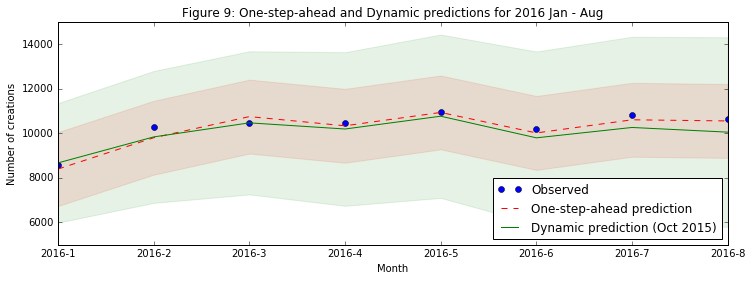

In [321]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
# Dynamic predictions
predict_dy = res.get_prediction(dynamic='2015-10-01')
predict_dy_ci = predict_dy.conf_int()
# Graph
fig, ax = plt.subplots(figsize=(12,4))
npre = 4
ax.set(title='New creations per month', xlabel='Month', ylabel='Number of creations')
#Plot data points
df3 = df2[:].set_index('Month')
df3.ix['2016-1':'2016-8','Created'].plot(ax=ax, style='o', label='Observed')
# Plot predictions
mean1 = predict.predicted_mean['2016-01':]
mean1 = mean1.to_frame(name='Predicted')
mean1['Month'] = mean1.index
mean1.index = range(8)
mean1.ix[:,'Predicted'].plot(ax=ax, style='r--', label='One-step-ahead prediction')
#add the confidence interval of the on-step prediction.
ci = predict_ci.ix['2016-01':] 
ax.fill_between(mean1.index, ci.ix[:,'lower Created'], ci.ix[:,'upper Created'], color='r', alpha=0.1)
# dynamic predition
mean2 = predict_dy.predicted_mean['2016-01':]
mean2 = mean2.to_frame(name='Predicted')
mean2['Month'] = mean2.index
mean2.index = range(8)
mean2.ix[:, 'Predicted'].plot(ax=ax, style='g', label='Dynamic prediction (Oct 2015)')
#add the confidence interval
ci_1 = predict_dy_ci.ix['2016-01':]
ax.fill_between(mean1.index, ci_1.ix[:,'lower Created'], ci_1.ix[:,'upper Created'], color='g', alpha=0.1)
legend = ax.legend(loc='lower right')
plt.title('Figure 9: One-step-ahead and Dynamic predictions for 2016 Jan - Aug')



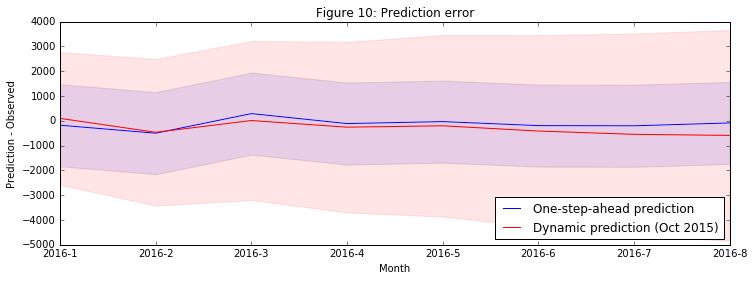

In [317]:
# Prediction error
# Graph
fig, ax = plt.subplots(figsize=(12,4))
npre = 4
ax.set(title='Figure 10: Prediction error', xlabel='Date', ylabel='Prediction - Observed')
df4 = df3.ix['2016-1':, 'Created']
for i in range(8):
    df4.iloc[i] = error1.iloc[i]['error']
df4.ix[:,].plot(ax=ax, style='w', label='')
# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - ts
error1 = predict_error['2016-01':].to_frame(name='error')
error1['Month'] = error1.index
error1.index = range(8)
error1.ix[:,'error'].plot(ax=ax, label='One-step-ahead prediction')

ci = predict_ci.ix['2016-01-01':].copy()
ci.iloc[:,0] -= ts.loc['2016-01-01':]
ci.iloc[:,1] -= ts.loc['2016-01-01':]
ax.fill_between(error1.index, ci.ix[:,0], ci.ix[:,1], alpha=0.1)

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - ts
error2 =predict_dy_error['2016-01':].to_frame(name='error')
error2['Month'] = error2.index
error2.index = range(8)
error2.ix[:, 'error'].plot(ax=ax, style='r', label='Dynamic prediction (Oct 2015)')

ci = predict_dy_ci.ix['2016-01-01':].copy()
ci.iloc[:,0] -= ts.loc['2016-01-01':]
ci.iloc[:,1] -= ts.loc['2016-01-01':]
ax.fill_between(error1.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower right');
legend.get_frame().set_facecolor('w')

ts.ix[:, ]

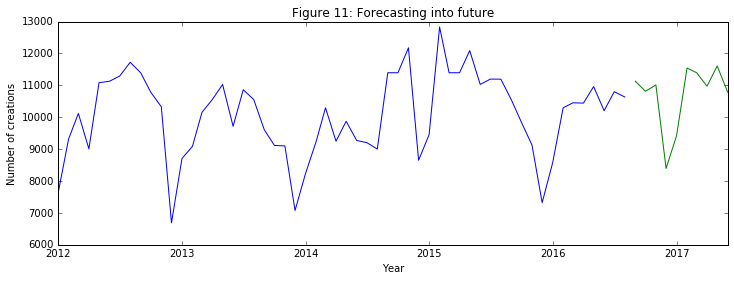

In [293]:
# predict into the future
# Graph
fig, ax = plt.subplots(figsize=(12,4))
npre = 4
ax.set(title='Figure 11: Forecasting into future', xlabel='Year', ylabel='Number of creations')
# first, add some new date points.
start = datetime.datetime.strptime("2016-09-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns = ['Forecast'])
df= pd.concat([ts, future])
df['Forecast'] = res.predict(start = 56, end = 65, dynamic= True)  
#df[[0, 'Forecast']].ix[-65:].plot(figsize=(12, 8)) 
plt.plot(df.index, df[0], label='sdf')
plt.plot(df.index, df['Forecast'] , label='ldsdfs')
plt.show()